<a href="https://colab.research.google.com/github/DeanHazineh/pytorch-deeplearning-examples/blob/main/CLIP_SearchEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

First, we import the necessary modules. Note that I am running this on a machine with CUDA enabled GPU.

The goal of this notebook is to explore utilizing CLIP to create an examplary text-to-image search on the TinyImageNet dataset. To speed up ranking searches, we will test using the Faiss library by facebook research.

In [ ]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

print("Pytorch version: ", torch.__version__)
print("GPU Available: ", torch.cuda.is_available())

import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
import random
from textwrap import wrap


Pytorch version:  1.13.1+cu116
GPU Available:  True


In [ ]:
!git clone https://github.com/openai/CLIP.git
%cd /content/CLIP
!pip install -r requirements.txt
!python setup.py develop

fatal: destination path 'CLIP' already exists and is not an empty directory.
/content/CLIP
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
running develop
running egg_info
writing clip.egg-info/PKG-INFO
writing dependency_links to clip.egg-info/dependency_links.txt
writing requirements to clip.egg-info/requires.txt
writing top-level names to clip.egg-info/top_level.txt
file clip.py (for module clip) not found
reading manifest file 'clip.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'clip.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.8/dist-packages/clip.egg-link (link to .)
clip 1.0 is already the active version in easy-install.pth

Installed /content/CLIP
Processing dependencies for clip==1.0
Searching for torchvision==0.14.1+cu116
Best match: torchvision 0.14.1+cu116
Adding torchvision 0.14.1+cu116 to easy-install.pth file

Using /usr/local/

In [ ]:
import clip

In [ ]:
!pip3 install faiss-gpu
import faiss
import faiss.contrib.torch_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# The CLIP Paper

Description of the CLIP Paper:

An underlying goal of the CLIP paper was to demonstrate the ability to use the massively abundant "weak-supervision" of image and text data from the internet for model pre-training and zero-shot learning. This is a step away from the gold-standard of high-quality crowd-labeled datasets which are substantially smaller in size. While this principle has been used before, the authors note in the introduction that a key difference is scale (difference in technology inherrently assumed as well since transformers did not exist at the time of some previous consideration). 

Many of the current, alternative datasets with text labels are relatively small. They note that YFCC100M is a possible dataset candidate; however, there was only approximatey 15 million images with suitable quality natural language titles or dsecirptions in english. To this end, the authors of the paper created a new dataset of 400 million images-text pairs to use in their work. Notably, the ultimate goal of demonstrating the potential of natural language supervision requires such large quantities of data that are also general enough to learn braod language to representation connections. The content of their dataset is collected from publicly available sources on the internet (I did not see specific details of where in the main text). The process is as follows: they first create a 500,000 "query" word list generated by identifying all words occuring at least 100 times in the English version of wikipedia. They also add bi-grams, article titles, and entries from WordNet synsets. A search for images with these query texts are then done and the dataset is balanced by limiting 20,000 image-text pairs per query. This is dubbed the WebImageTex.

The architecture of CLIP is similar to ViTex but it has a few notable modifications (I included the image for my own future reference). First, it utilizes a CNN (variant of ResNet-50) as an image encoder which takes in an RGB image and produces a "feature/embedding vector" that is 1x512 (per image). The model also includes a text encoder based on a transformer (variant of Vision Transformer ViT) which takes input text and produces another "feature/embedding" vector. The model differs from prior works in one key way regarding the text-encoding. Their goal is to predict only the text as a whole that matches to an image rather than the exact sentence. In this sense, they take a sentence as the text input and tokenize it to a bag-of-words form. This tokenization encodes the number of times any possible word apears in the sentence (regardless of order). This token is then passed to the text encoder to get the feature vector. It is interesting to see that this change yields a 4x speedup in learning according to the authors. 

The training takes the image-text pairs from their WebImageTex dataset, passes it through the image and text encoder, respectively, and then compares the two outputted feature vectors. For an input pair that is matched, the two encoders should learn to produce the same or similar feature vectors. This principle guides the training objective. A predictive loss function would be to pass in the image-text pairs as a batch and use gradient descent of the model parameters to maximize the cosine-similarity between the two feature vectors. Alternatively, the training is done in a slightly different way. A contrastive learning approach is use (rather than predictive) which is found to train better and converge 4x faster. The contrastive approach takes in a batch of text encodings and produces a set of feature vectors; and similarly done for a batch of images. One then considers the cosine similarity of every pair of text-feature vectors and image-feature vectors. The similarity should be maximized when the pair is matched and minimized when the pair is not (this is shown in the block of $T_i$ and $I_i$ below). This similarity matrix is computed and a cross-entropy loss is taken vs a diagonal matrix.

The image encoder in CLIP and the Myrtle5 classifier used in the previous problem are similar in that they both have conv2D layers which do the bulk of the work for transforming an imput image to an output vector; strictly speaking, CLIP has more nuanced architecture changes including the utilization of transformers. One notable difference is that Myrtle5 outputs a vector which directly relates to classification in the One-of-N label sense. The output of the image-encoder from CLIP cannot be directly interpretted in such fashion. The output feature vector maps to a tokenized text in CLIP by the text-encoder transformation. One motivation is to use CLIP for pre-training. The image-encoder learns meaningful image to text representations and a classifier could be attached on top and finely trained for a particular task or dataset. It enables some level of "transferable" intelligence and can even be used directly on other datasets in a zero-shot sense. As we will see in the rest of the assignment, it is also quite good for image search. We can precompute the feature vector for all potential images in a dataset and given a user passed text query, we can return images that match the representation of the text. 

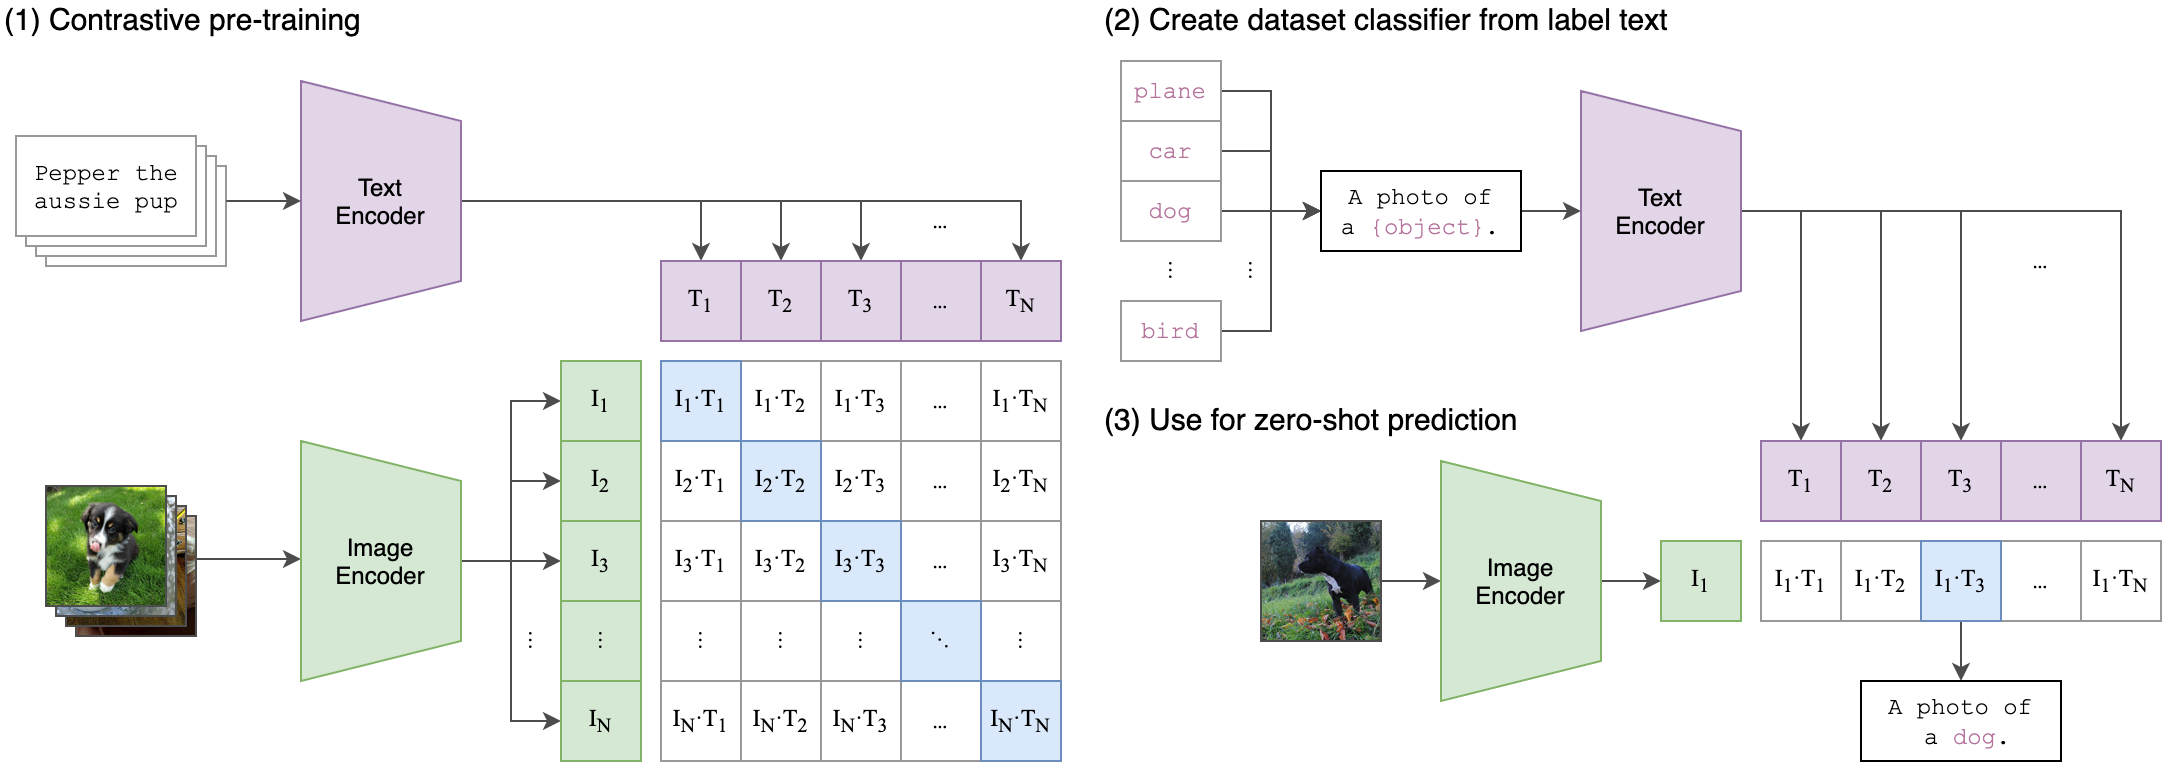

In [ ]:
import IPython.display as disp
disp.display(disp.Image("/content/CLIP/CLIP.png",width=1200))

# Basic Text-Image Search 

## Test fast vector comparison with Faiss

First, I do some basic explorations with CLIP and Faiss. This helps ensure we have installed it correctly and understand the nuances of how they work

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# We will not be training CLIP in any part of this notebook so freeze the gradients 
# If you don't do this, you will run into memory overflow surely
for param in model.parameters():
    param.requires_grad = False

As discussed in the paper, we use CLIP to encode an image into a [1x512] feature embedding vector. Basic preprocessing is done to normalize the mean and standard deviation of the image. CLIP is also used to create a corresponding text embedding vector. Tokenization serves to implement the "bag-of-words" treatment for input sentences. By computing the cosine similarity between a given image embedding feature vector (normalized) with a set of text embeddings (normalized), we can see which text pairs to that image.

In [ ]:
# Encode the image
img = Image.open("/content/CLIP/CLIP.png")
image = preprocess(img).unsqueeze(0).to(device)
image_features = model.encode_image(image)

# Encode the text
text_desc = ["a diagram", "a dog", "a cat"]
text = clip.tokenize(text_desc).to(device)
text_features = model.encode_text(text)
print(text_features.shape)

with torch.no_grad():
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    print("label:", text_desc)
    print("Label probs:", probs) 

torch.Size([3, 512])
label: ['a diagram', 'a dog', 'a cat']
Label probs: [[0.9927   0.004253 0.002968]]


Faiss is installed and enables rapid vector searching. Remember to use IndexFlatIP on normalized vectors in order to obtain the equivalent cosine similarity metric (not the default L2 search). This is tested below where we indeed observe that the test image matches correctly to the "a diagram" text.

In [ ]:
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)
text_features = model.encode_text(text)
text_features /= text_features.norm(dim=-1, keepdim=True)

res = faiss.StandardGpuResources()  # use a single GPU
index = faiss.IndexFlatIP(512) # Cosine similarity is innerproduct on normalized vectors
index = faiss.index_cpu_to_gpu(res, 0, index)
index.add(text_features.detach().cpu().numpy().astype('float32'))

image_feature = model.encode_image(preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device))
image_feature /= image_feature.norm(dim=-1, keepdim=True)
query = image_feature.detach().cpu().numpy().astype('float32')

k = 3
D, I = index.search(query,k)
print(D, I)

[[0.25560158 0.20103168 0.19750607]] [[0 1 2]]


## Load and View images from TinyImageNet

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

--2023-02-23 02:53:26--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.2’

tiny-imagenet-200.z 100%[===================>] 236.61M  15.5MB/s    in 18s     

2023-02-23 02:53:45 (12.9 MB/s) - ‘tiny-imagenet-200.zip.2’ saved [248100043/248100043]

replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Throughout, we use the TinyImageNet dataset. The first thing we want to do is take a look and explore the data. While there are actually ways to load the dataset via import (I read about deeplake's pytorch loader), I simply downloaded the dataset onto my disk and will read from memory. Code to do this is shown following. 

In [ ]:
# Define paths for the loaded
datapath = "/content/CLIP/tiny-imagenet-200/"
train_path = datapath + "train/"
val_path = datapath + "val/"

In [ ]:
# Create a dictionary for the validation file names to class id
val_img_dict = {}
with open(val_path+"val_annotations.txt", 'r') as fp:
    data = fp.readlines()
    for line in data:
        # Line has format of image file name, class name, X, Y, H, W 
        words = line.split('\t')
        val_img_dict[words[0]] = words[1]

# Create a dictionary that matches class id to text descriptions
class_word_dict = {}
with open(datapath+"words.txt") as fp:
    data = fp.readlines()
    for line in data:
        words = line.split('\t')
        text = words[1].split()
        class_word_dict[words[0]] = text

The strategy I use is a little weird but it worked and came in handy later. I create a function which returns a list of image paths for n randomly selected images (either in the training or validation folder). We also return a list of the corresponding class ids for the image paths selected. The class ids can be matched to strings with the dictionary above. A helper function to visualize sampled images is also written: 

In [ ]:
def gen_random_train_path(num_imgs):
    """ Return num_imgs randomly selected img file paths and corresponding class labels from training set """

    # List the training path category folders
    train_fold_id = os.listdir(train_path)
    num_fold = len(train_fold_id)

    list_img_paths = []
    list_img_cat = []
    # Select from the folders randomly
    for fold_idx in random.sample(list(np.arange(0,num_fold,1)), num_imgs):
        img_path = train_path + train_fold_id[fold_idx]+"/images/"
        list_imgs = os.listdir(img_path)
        sel_file_idx = random.sample(list(np.arange(0,len(list_imgs),1)),1)[0]

        list_img_paths.append(img_path + list_imgs[sel_file_idx])
        list_img_cat.append(train_fold_id[fold_idx])
    
    return list_img_paths, list_img_cat


def gen_random_val_path(num_imgs):
    """Return num_imgs randomly selected img file paths and corresponding class labels from validation set"""
    val_path = datapath+"val/images/"
    val_img_ids = os.listdir(val_path)
    list_img_paths = []
    list_img_cat = []

    for img_idx in random.sample(list(np.arange(0, len(val_img_ids),1)), num_imgs):
        list_img_paths.append(val_path + val_img_ids[img_idx])
        list_img_cat.append(val_img_dict[val_img_ids[img_idx]])
    
    return list_img_paths, list_img_cat


def addAxis(fig, nrow, ncol):
    axList = []
    for i in range(nrow*ncol):
        axList.append(fig.add_subplot(nrow, ncol, i+1))
    return axList


def display_batch_imgs(train):
    if train: 
        get_fun = gen_random_train_path
    else:
        get_fun = gen_random_val_path
    img_paths, img_cat = get_fun(25)
    
    img_scale = 2
    fig = plt.figure(figsize=(img_scale*5, img_scale*5))
    axList = addAxis(fig, 5, 5)

    for i in range(25):
        # show image
        imgnp = np.array(Image.open(img_paths[i]))
        axList[i].imshow(imgnp)
        axList[i].xaxis.set_visible(False)
        axList[i].yaxis.set_visible(False)

        # Add category and text label
        text = np.array2string(np.array(class_word_dict[img_cat[i]]))
        axList[i].set_title(text, loc='center', wrap=True, fontsize=6)

    return

Folllowing, I plot a handful of randomly selected images from the training and validation dataset. We may note the following:

One of the main challenges of this dataset that I see is multi-object ambiguity. In many cases, I can point out multiple objects in the picture but it is not always clear what is the primary object for which the caption describes. For pictures like this, there is no other descriptors in the text. This will make it challenging to learn feature embeddidngs for the image that match to the word. 

There is also color ambiguity, like where we have a chair picture saturated yellow vs a more realistic picture of chairs on a dinner table. The same object can take many different apperances with lighting or angles that could be quite difficult to hope to generalize. For "human search", I think the latter is not so important as compared to the former where we too would have difficulty assigning one text to a picture with multiple targets.

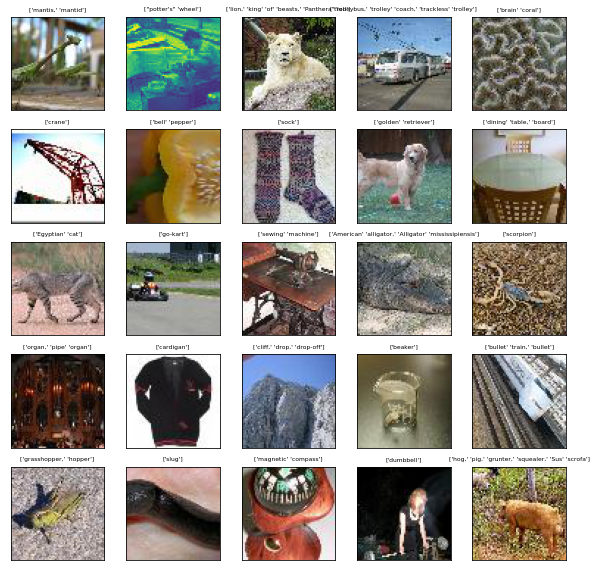

In [ ]:
# Show sample of images from train dataset
display_batch_imgs(train=True)

Previous was a collage of images drawn randomly from the training data. Following are a collection of images from the validation data. The conclusions are largely the same. In all, the dataset seems reasonable and well controlled to use as is. 

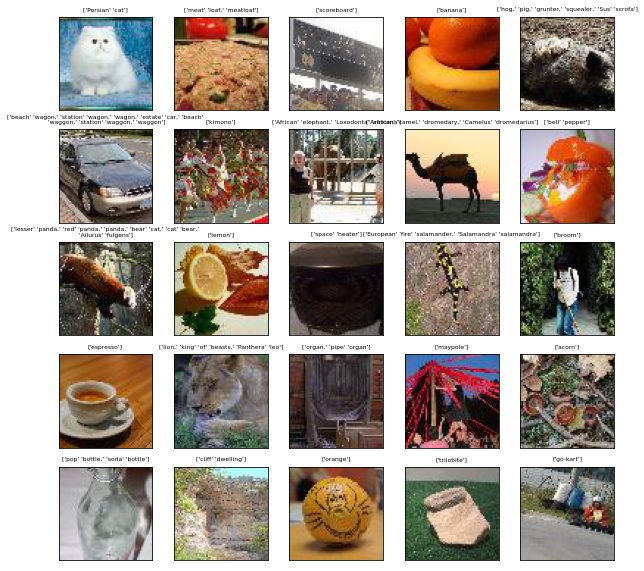

In [ ]:
# Show sample of images from val dataset
display_batch_imgs(train=False)

## Zero-Shot Search over Validation Set

Here, I write code to take a query text string and to utilize CLIP to search for matching images from the validation set. In the following code functions, I sweep through the validation dataset and compute the image-feature vector. These vectors are stored into a Faiss index so we can search through them to find a set of matching images. I believe the implementation is largely unremarkable but we will show the output from this follwing.

In [ ]:
device = 'cuda'
val_path = datapath+"val/images/"
val_img_ids = natsorted(os.listdir(val_path))

def compute_val_features():
    """Precompute CLIP embeddings for each image in the validation set"""
    res = faiss.StandardGpuResources()  # use a single GPU
    index = faiss.IndexFlatIP(512)
    index = faiss.index_cpu_to_gpu(res, 0, index)

    for img_name in val_img_ids:
        image = preprocess(Image.open(datapath+"val/images/"+img_name)).unsqueeze(0).to(device)
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        index.add(image_features.detach().cpu().numpy().astype('float32'))

    return index

def display_sampled_imgs(img_idx, img_scale=20):
    num_imgs = len(img_idx) 
    fig = plt.figure(figsize=(img_scale*1, img_scale*num_imgs))
    axList = addAxis(fig, 1, num_imgs)
    
    for i, idx in enumerate(img_idx):
        # show image
        imgnp = np.array(Image.open(val_path + val_img_ids[idx]))
        axList[i].imshow(imgnp)
        axList[i].xaxis.set_visible(False)
        axList[i].yaxis.set_visible(False)

        ## Add category and text label
        text_img = np.array2string(np.array(class_word_dict[val_img_dict[val_img_ids[idx]]]))

        titlestr = val_img_ids[idx] + "\n" + text_img
        axList[i].set_title(titlestr, loc='center', wrap=True, fontsize=6)

    return

def image_search(text, faiss_index, k=5):
    token_text = clip.tokenize([text]).to(device)
    query = model.encode_text(token_text)
    query /= query.norm(dim=-1, keepdim=True)
    _, I = faiss_index.search(query.detach().cpu().numpy().astype('float32'), k)
    display_sampled_imgs(np.squeeze(I))

    return

In [ ]:
val_index = compute_val_features()
val_index.ntotal

10000

I run the image search with the query "go-kart" (and the sentence "a picture of a go-kart"). The CLIP algorithm and feature search appears to work well on the TinyImageDataset in the zero-shot case! In both cases, we are 5/5 on retrieving images with the ground-truth label of go-kart.


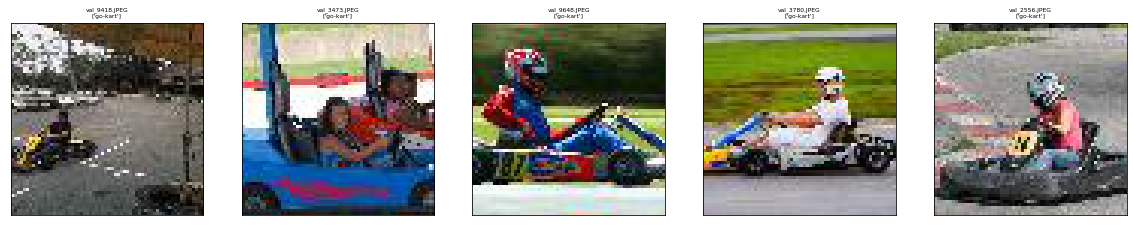

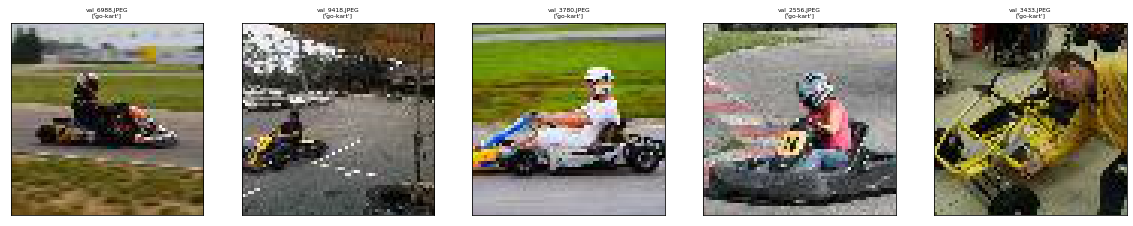

In [ ]:
image_search("go-kart", val_index, k=5)
image_search("a picture of a go-kart", val_index, k=5)


We can play around and try a few more examples. Below, we observe that we are able to correctly retrieve images with adjective qualifiers like "car" vs "red car". One place where I find it did not work well is asking for a picture of the word car. I was hoping to see text with letters C A R appearing somewhere but this appears to be too tricky (although "human search" could do this easily).

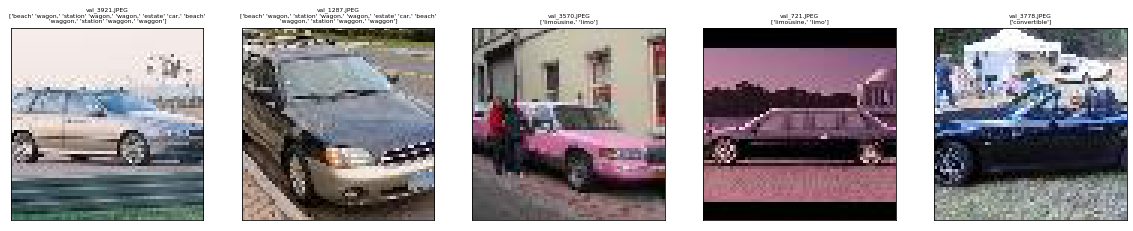

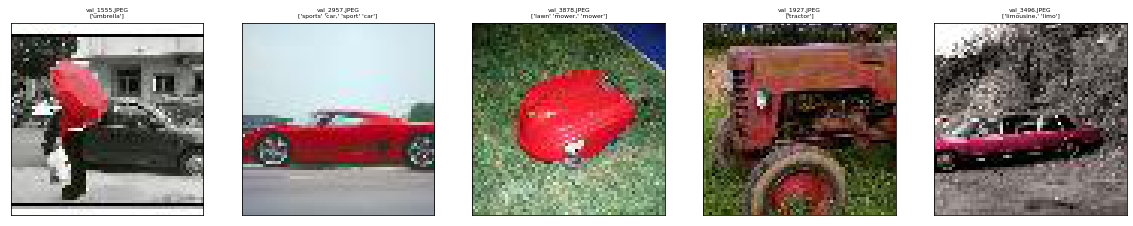

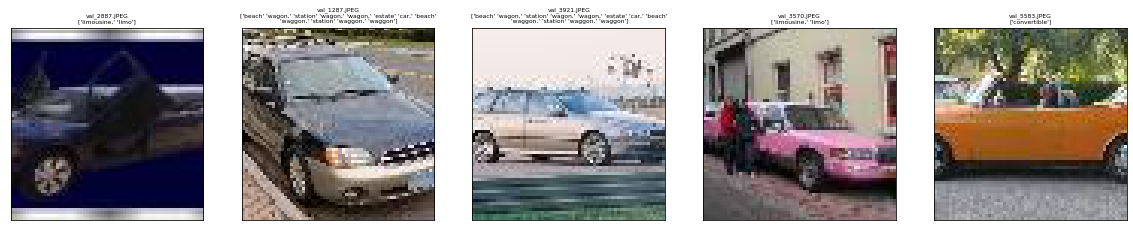

In [ ]:
image_search("a picture of a car", val_index, k=5)
image_search("a picture of a red car", val_index, k=5)
image_search("text with the word CAR", val_index, k=5)


Surprisingly, I don't see many mistakes while testing on random words that I think of. It has some issues disassociating desk from computer when given the query "computer" but this matches our intuition from before about the difficulty when there are multiple targets in the image and a single text. Computer images usually come with a desk or a person!

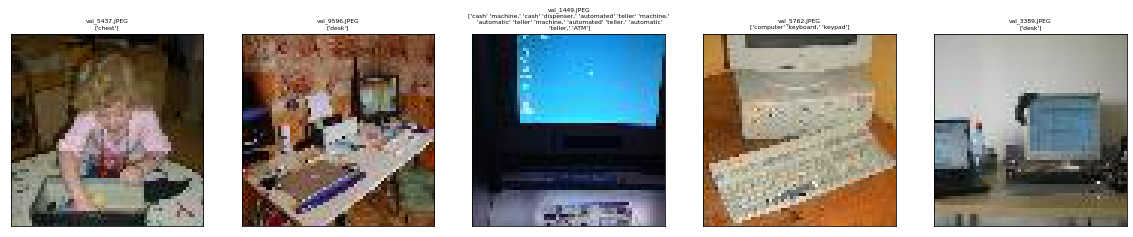

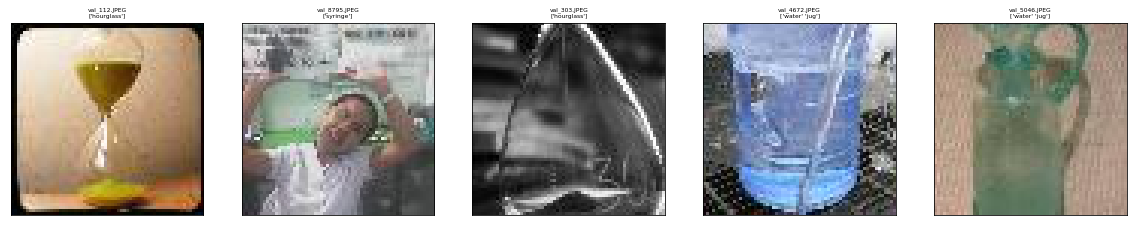

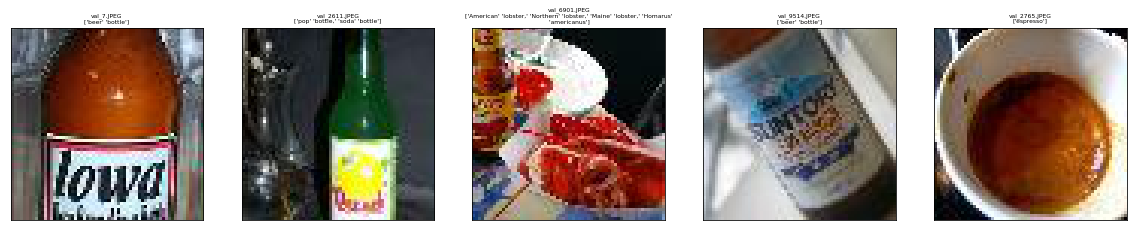

In [ ]:
image_search("computer", val_index, k=5)
image_search("glass", val_index, k=5)
image_search("hot-sauce", val_index, k=5)

Now we try to test the accuracy more systematically. Following, we compute the image search accuracy for every class in the TinyImageNet validation set. Specifically, there are 200 classes and each class has exactly 50 images. The strategy is to get the true caption/text for each class and use it to query+retrieve 50 of the closest matched images using the methods above. We then see which of those 50 retrieved images actually correctly belonged to that class.

We find that the accuracy varies greatly depending on the query/class. For some classes (like the ones I just happened to choose above), the search algorithm works well and we have an accuracy above 80 percent. For other classes, the algorithm fails and of the 50 images we retrieved, less than 10 percent actually belonged to the class. The average accuracy across all labels is printed in the code following and we get a value of 52.68%.  

Average accuracy across all labels:  0.5271


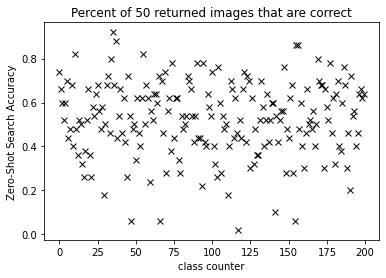

In [ ]:
val_classes = list(set([val for key, val in val_img_dict.items()]))
accuracy = []
num_imgs_per_class = 50

#for this_class in val_classes:
for this_class in val_classes:
    # For class labels that have multiple words, merge them into a sentence
    class_label = " ".join(class_word_dict[this_class])
    token_text = clip.tokenize([class_label]).to(device)
    query = model.encode_text(token_text)
    query /= query.norm(dim=-1, keepdim=True)
    
    # Get the 50 nearest images in the form of file index
    _, I = val_index.search(query.detach().cpu().numpy().astype('float32'), num_imgs_per_class)

    # For each of the 50 returned images, see if the true class was correct 
    num_correct = 0
    for returned_idx in np.squeeze(I):
        return_img_name = val_img_ids[returned_idx]
        if val_img_dict[return_img_name] == this_class:
            num_correct +=1
    accuracy.append(num_correct/num_imgs_per_class)
accuracy = np.array(accuracy)

print("Average accuracy across all labels: ", np.mean(accuracy))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(accuracy, 'kx')
ax.set_xlabel("class counter")
ax.set_ylabel("Zero-Shot Search Accuracy")
ax.set_title("Percent of 50 returned images that are correct");

We want to look at this more closely. Below, I select the four worst performing class queries and display a set of images retrieved from the search. The query "nail" is the worst performing; in the displayed images, we see lots of feet or hand images where nails are present but the text caption is something different. This is tricky even for human search. Some images are completely wrong but still look like the query so the cosine similary of the CLIP algorithm is not so shocking. 

Class id n03804744, Accuracy: 0.02, Label: nail
Class id n04067472, Accuracy: 0.06, Label: reel
Class id n03160309, Accuracy: 0.06, Label: dam, dike, dyke
Class id n02815834, Accuracy: 0.06, Label: beaker


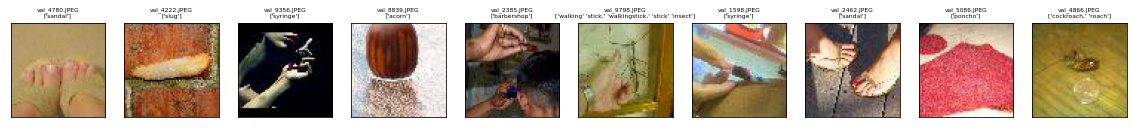

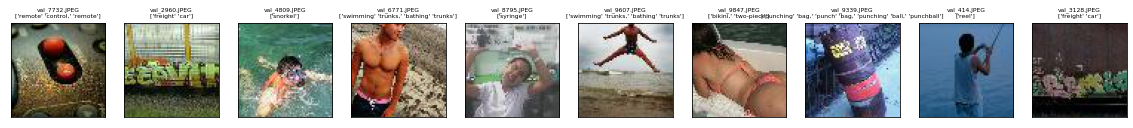

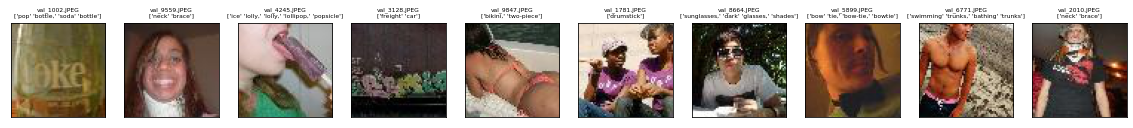

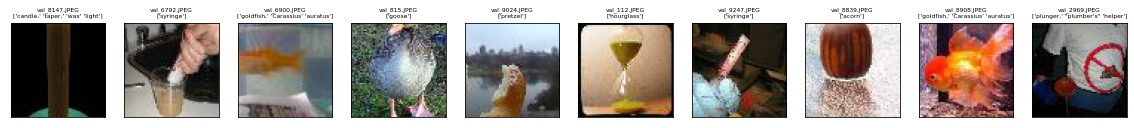

In [ ]:
sort_idx = np.argsort(accuracy)

# Show worst performing searches
lowest_idx_set = sort_idx[0:4]
for idx in lowest_idx_set:
    this_class = val_classes[idx]
    class_label = " ".join(class_word_dict[this_class])
    print(f"Class id {this_class}, Accuracy: {accuracy[idx]}, Label: {class_label}")
    image_search(class_label, val_index, k=10)


The algorithm does amazing on images that usually dont vary alot like a schoolbus. 

Class id n07920052, Accuracy: 0.82, Label: espresso
Class id n02279972, Accuracy: 0.86, Label: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
Class id n02056570, Accuracy: 0.86, Label: king penguin, Aptenodytes patagonica
Class id n02002724, Accuracy: 0.88, Label: black stork, Ciconia nigra
Class id n04146614, Accuracy: 0.92, Label: school bus


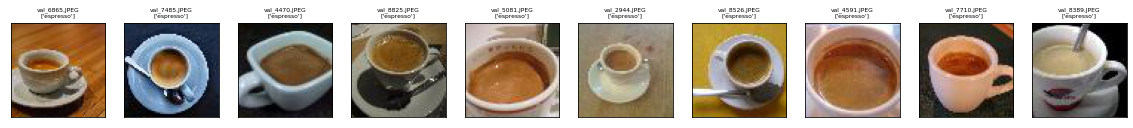

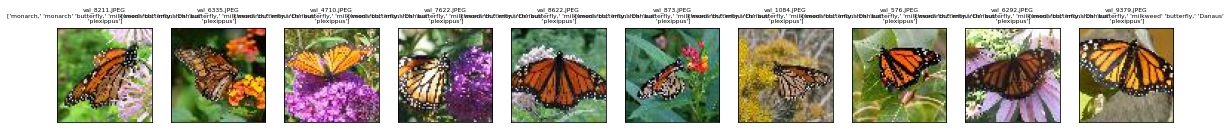

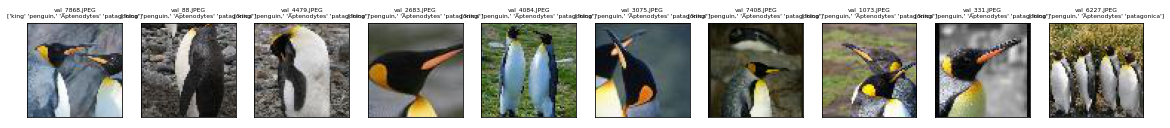

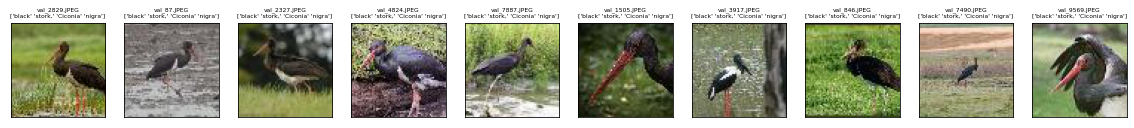

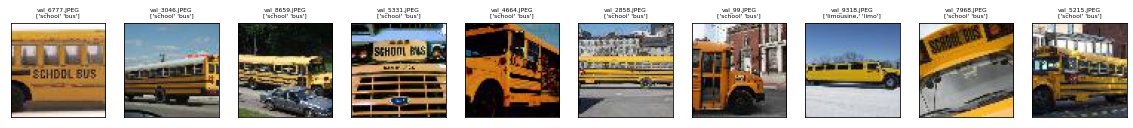

In [ ]:
# Show the best performing searches
best_idx_set = sort_idx[-5:]
for idx in best_idx_set:
    this_class = val_classes[idx]
    class_label = " ".join(class_word_dict[this_class])
    print(f"Class id {this_class}, Accuracy: {accuracy[idx]}, Label: {class_label}")
    image_search(class_label, val_index, k=10)

# Improving the Search Engine

We now consider modifications that would lead to improvements on a toy-version of the problem. We suppose that there are only four classes (chosen at random) and a fifth class corresponding to other.

By training an MLP on the TinyImageNet training data, we believe that one could classify images more accurately on this set by combining the zero-shot CLIP image embeddings with the MLP classifier layer. Following I present code to create and train an MLP (with CLIP frozen) for classification.

For the MLP, I consider a model with two, hidden dense layers of 64 (or 32 neurons) in each. It is largely a standard MLP with ReLu activation in the hidden layers and a Sigmoid activation on the final layer which is useful for probalistic interpretation.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
for param in clip_model.parameters():
    param.requires_grad = False

class MLP_64(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 5),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


class MLP_32(nn.Module):  
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 5),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In the code snippet below, a custom data loader is made which imports a batch of image files and creates its corresponding, true label (5-length vector of zeros with a 1 in the index corresponding to the class). Standard helper functions for training the MLP follows. The output of the MLP is passed to a softmax and then a CrossEntropy loss is utilized.

In [ ]:
# Define four random labels from the set of training data (else it is other category)
# as was instructed on the assignment
train_labels = np.array(os.listdir(train_path))
rand_select_idx = random.sample(list(np.arange(0, len(train_labels), 1)), 4)
select_labels = train_labels[rand_select_idx]

#Create a custom dataloader 
def custom_dataloader_trainTiny(batch_size, train=True):
    if train:
        img_path, img_cat = gen_random_train_path(batch_size)
    else: # val
        img_path, img_cat = gen_random_val_path(batch_size)

    im_batch = []
    im_mlp_label = []
    for i, impath in enumerate(img_path):
        ### Get image (pre-processed to be passed to clip later)
        this_im = preprocess(Image.open(impath)).unsqueeze(0)
        im_batch.append(this_im)

        # Get label
        label_vec = np.zeros((5))
        bool_vec = (select_labels == img_cat[i])
        if any(bool_vec):
            label_vec[np.where(bool_vec==True)[0]] = 1.0
        else: 
            label_vec[4]=1.0
        im_mlp_label.append(np.expand_dims(label_vec,0))
        
    im_batch = np.squeeze(np.stack(im_batch, axis=0))
    im_mlp_label = np.squeeze(np.stack(im_mlp_label, axis=1))
    return torch.tensor(im_batch), torch.tensor(im_mlp_label)


In [ ]:
def train_call(mlp_model, opt, loss_func, batch_size):
    mlp_model.train()
    mlp_model.to(device)
    opt.zero_grad()

    # Load images from the training data
    with torch.no_grad():
        images, labels = custom_dataloader_trainTiny(batch_size, train=True)    
        images = images.type(torch.float32).to(device)
        labels = labels.type(torch.float32).to(device)

        input_imFeature = clip_model.encode_image(images).type(torch.float32)
        input_imFeature /= input_imFeature.norm(dim=-1, keepdim=True)
        # #renormalize input 
        # input_imFeature = input_imFeature - torch.min(input_imFeature)
        # input_imFeature /= torch.max(input_imFeature)

    # Forward and backwards calculation
    output = mlp_model(input_imFeature)
    output = F.softmax(output, dim=1)
    loss = loss_func(output, labels)
    loss.backward()
    opt.step()
    
    # Note the accuracy in classification on this miniproblem
    with torch.no_grad():
        _, label_class = torch.max(labels, dim=1)
        _, pred_class = torch.max(output, dim=1)
        num_correct = (pred_class == label_class).float().sum() 
    
    return loss.item(), num_correct.item()/batch_size

def eval_call(mlp_model, loss_func, val_batch_size):
    mlp_model.eval()
    mlp_model.to(device)

    images, labels = custom_dataloader_trainTiny(val_batch_size, train=False)
    images = images.type(torch.float32).to(device)
    labels = labels.type(torch.float32).to(device)
    input_imFeature = clip_model.encode_image(images).type(torch.float32)
    input_imFeature /= input_imFeature.norm(dim=-1, keepdim=True)
    
    output = mlp_model(input_imFeature)
    output = F.softmax(output, dim=1)
    loss = loss_func(output, labels)

    _, label_class = torch.max(labels, dim=1)
    _, pred_class = torch.max(output, dim=1)
    num_correct = (pred_class == label_class).float().sum() 

    return loss.item(), num_correct.item()/val_batch_size

def train_MLP_classifier(mlp_model, num_steps, batch_size):
    # Initialize training for MLP
    opt = torch.optim.Adam(mlp_model.parameters(), .5e-3)
    loss_func = nn.CrossEntropyLoss()
    val_batch_size = 200

    hold_train_loss = []
    hold_train_acc = []
    hold_val_loss = []
    hold_val_acc = []

    # loop through training steps
    for i in tqdm(range(num_steps)):
        # Train 
        train_loss, train_acc = train_call(mlp_model, opt, loss_func, batch_size)
        hold_train_loss.append(train_loss)
        hold_train_acc.append(train_acc)

        # Evaluate 
        val_loss, val_acc = eval_call(mlp_model, loss_func, val_batch_size)
        hold_val_loss.append(val_loss)
        hold_val_acc.append(val_acc)

    # return losses as dictionary
    history = {"train_loss":hold_train_loss, "train_acc": hold_train_acc, "val_loss": hold_val_loss, "val_acc": hold_val_acc}
    return mlp_model, history

The results of training the MLP are shown following. I find that both MLP's tested are able to correctly map the CLIP image feature vector to the correct classification (that being one of the four randomly selected classes or other).

100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


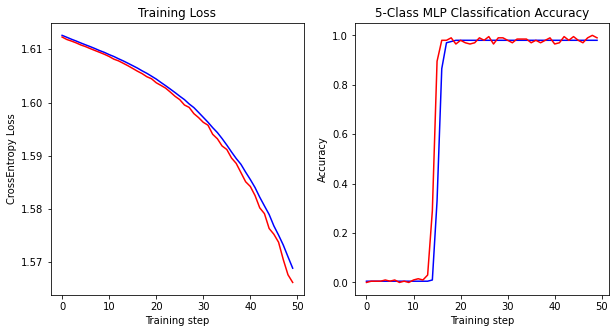

In [ ]:
mlp_model = MLP_64()
mlp_model, history = train_MLP_classifier(mlp_model, 50, batch_size=200)

fig = plt.figure(figsize=(10,5))
ax = addAxis(fig, 1,2)
ax[0].plot(history["train_loss"], 'b-')
ax[0].plot(history["val_loss"], 'r-')
ax[0].set_xlabel("Training step")
ax[0].set_ylabel("CrossEntropy Loss")
ax[0].set_title("Training Loss")

ax[1].plot(history["train_acc"], 'b-')
ax[1].plot(history["val_acc"], 'r-')
ax[1].set_xlabel("Training step")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("5-Class MLP Classification Accuracy");

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


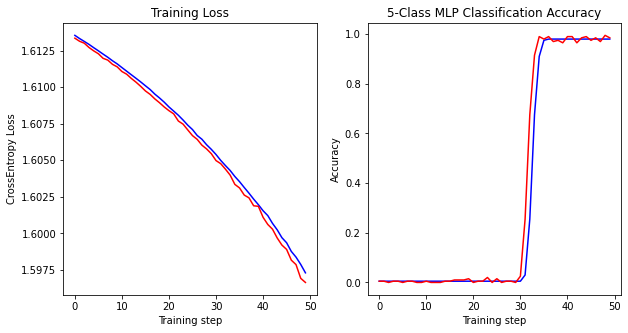

In [ ]:
mlp_model = MLP_32()
mlp_model, history = train_MLP_classifier(mlp_model, 50, batch_size=200)

fig = plt.figure(figsize=(10,5))
ax = addAxis(fig, 1,2)
ax[0].plot(history["train_loss"], 'b-')
ax[0].plot(history["val_loss"], 'r-')
ax[0].set_xlabel("Training step")
ax[0].set_ylabel("CrossEntropy Loss")
ax[0].set_title("Training Loss")

ax[1].plot(history["train_acc"], 'b-')
ax[1].plot(history["val_acc"], 'r-')
ax[1].set_xlabel("Training step")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("5-Class MLP Classification Accuracy");